In [25]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ, Aer, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit.tools.monitor import job_monitor

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [4]:
from math import pi

In [9]:
from qiskit_textbook.widgets import scalable_circuit

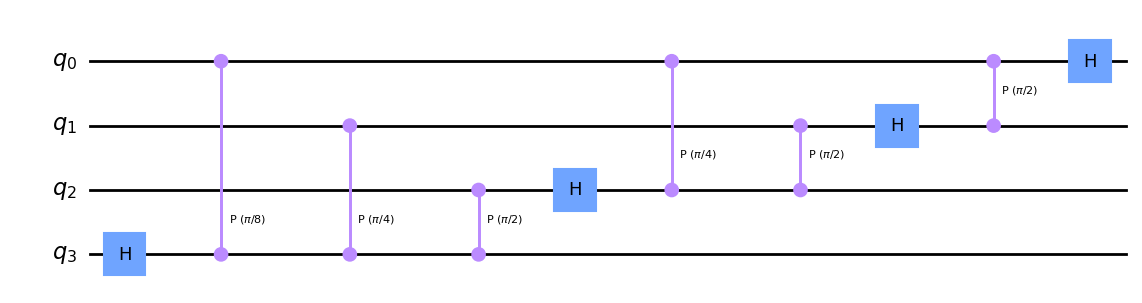

In [5]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

In [10]:
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\xb2\x00\x00\x01o\x08\x06\x00\x00\x00\x9f\n=o\x00…

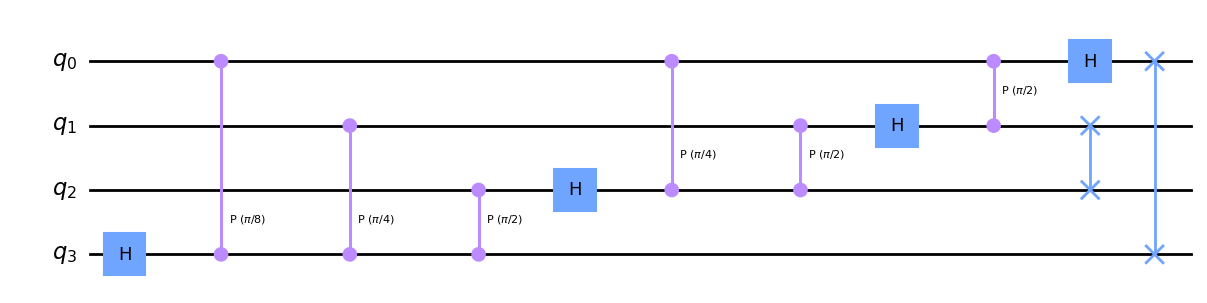

In [6]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw()

In [8]:
scalable_circuit(qft)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\x05\x00\x00\x01o\x08\x06\x00\x00\x00j\xc2\xcb.\x…

In [11]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

Putting our circuit in the Fourier state |5~>

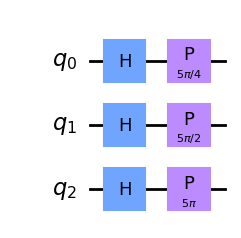

In [17]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

In [18]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2023-05-02 20:31:00,625: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito


In [19]:
backend

<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

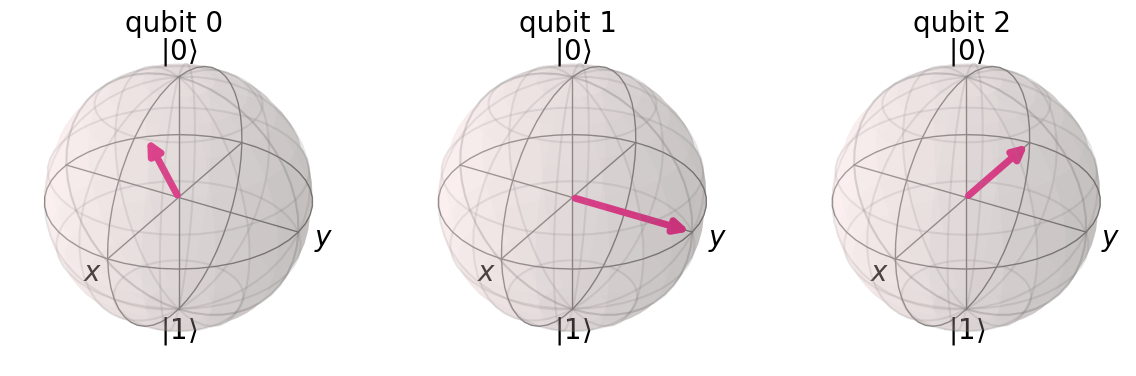

In [22]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

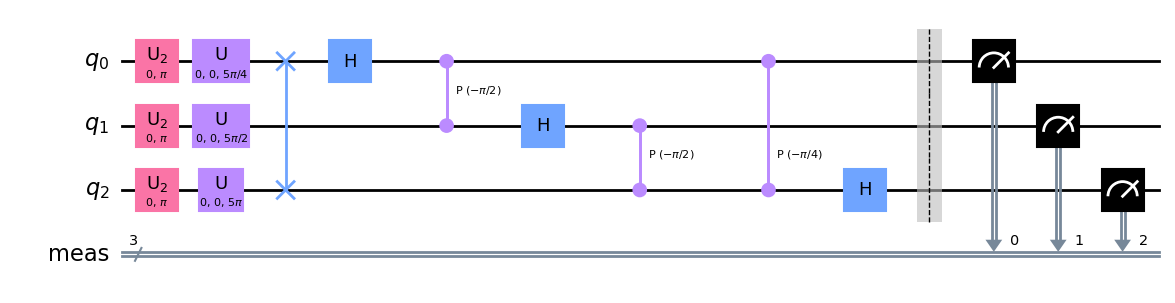

In [23]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

In [26]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


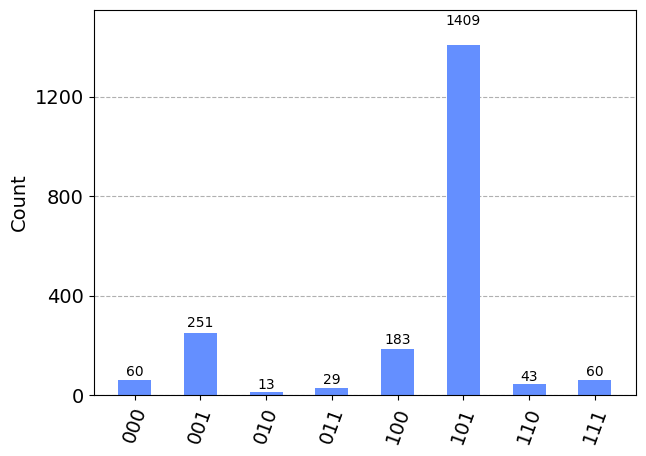

In [27]:
counts = job.result().get_counts()
plot_histogram(counts)

Seems like our inverse QFT function did work as it should!

In [28]:
qc.inverse??

Signature: qc.inverse() -> "'QuantumCircuit'"
Source:   
    def inverse(self) -> "QuantumCircuit":
        """Invert (take adjoint of) this circuit.

        This is done by recursively inverting all gates.

        Returns:
            QuantumCircuit: the inverted circuit

        Raises:
            CircuitError: if the circuit cannot be inverted.

        Examples:

            input:

            .. parsed-literal::

                     ┌───┐
                q_0: ┤ H ├─────■──────
                     └───┘┌────┴─────┐
                q_1: ─────┤ RX(1.57) ├
                          └──────────┘

            output:

            .. parsed-literal::

                                  ┌───┐
                q_0: ──────■──────┤ H ├
                     ┌─────┴─────┐└───┘
                q_1: ┤ RX(-1.57) ├─────
                     └───────────┘
        """
        inverse_circ = QuantumCircuit(
            self.qubits,
            self.clbits,
            *self.qregs,
            *se